Here, the problem of using electrical energy in households will be resolved, where a deep learning model will be made to predict the use of electrical energy every 1 hour for a day and find out how long the remaining electric pulses will run out.

### **The following is a description and explanation of the dataset**

- In a dataset, there is data on electricity consumption, namely train data and testing data.
- train data: data that will be used for deep learning model training.
- test data: data to be used for testing and evaluating the model.
- **actual id**: contains column data regarding the actual data id which is unique
- **pemakaian_listrik**: contains column data of the user's electricity consumption every 1 hour.
- **tanggal**: contains column data from the date of use of electricity users
- **nomorserial**: contains the serial number value used to identify the smartmeter user device.


# **Steps for Making Deep Learning Models**

## **1. Pre-processing Data**

**- Data train and Data test** : the data is obtained from taking pictures and calculating electricity consumption manually by subtracting the remaining electric pulses from the previous time and the current time. the data amounted to 522 data collected.

In [1]:
#import library

import numpy as np #import numpy library for manipulation array and matrics
import pandas as pd #import pandas library for maniputation data like table and columns (Dataframe).
import matplotlib.pyplot as plt #to plotting image graph
plt.style.use('classic')

%matplotlib inline

import time #importing delay

#importing tensorflow keras model LSTM

import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import seaborn as sns


In [ ]:
#mount google drive

from google.colab import drive
drive.mount('/content/drive')

In [3]:
#read data into dataframe on data

df_data = pd.read_excel('DATA/pemakaian listrik.xlsx')

In [4]:
#show dataframe with 5 data from initial data

df_data.head(5)

,tanggal,pulsa_listrik,pemakaian_listrik
0,2022-01-29 20:02:34,163.04,NaN
1,2022-01-29 21:02:43,162.37,0.67
2,2022-01-29 22:02:52,161.89,0.48
3,2022-01-29 23:03:01,161.42,0.47
4,2022-01-30 00:03:10,160.96,0.46


### **Review and Visualization** 
**What's the goal Review Data?**

- Reviewing the Data Used to get a complete picture of the data (review gambaran utuh datanya seperti apa).

  Such as Descriptive Value => Mean, Median, Q1, Q2, Q3, outliers and Others.

In [5]:
#retrieve the data needed in analyzing the data.
#data required is only data_electricity_use and date

data_deskripsi = df_data[['pemakaian_listrik']]

In [6]:
#see the data type in the training data column

data_deskripsi.dtypes

pemakaian_listrik    float64
dtype: object

In [7]:
#check data missing value

data_deskripsi.isna().sum()

pemakaian_listrik    8
dtype: int64

In [8]:
#see statistical descriptions on data 

data_deskripsi.describe()

,pemakaian_listrik
count,514.000000
mean,0.424183
std,0.142045
min,0.150000
25%,0.320000
50%,0.410000
75%,0.500000
max,1.040000


**data_deskripsi**

- total data = 514 (only the existing data is taken. NaN is ignored)

- average electricity usage is around 0.42

- the minimum value of all data is 0.15

- max value of all data is 1.04

- the standard deviation (data distribution) is 0.140951

In [9]:
#see the number of data columns and rows in data deskripsi

print(data_deskripsi.shape)
print(data_deskripsi.shape)

(522, 1)
(522, 1)


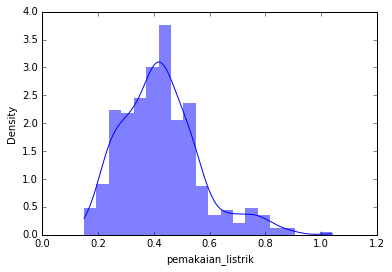

In [10]:
#Seeing the distribution of electricity consumption by using a histplot (graph histogram) to visualize the distribution of the data.

#show histogram visualization on train data
sns.histplot(data_deskripsi['pemakaian_listrik'], kde=True, stat="density", linewidth=0);

- standar deviation   = standard deviation is a statistical value used to determine how close the data from a sample is to
- normal distribution = The normal distribution is a probability function that shows the distribution or spread of a variable.

In [11]:
#Show IQR (Jangkauan Interquartile) on data_deskripsi

q1= data_deskripsi['pemakaian_listrik'].quantile(0.25)
q3 = data_deskripsi['pemakaian_listrik'].quantile(0.75)
iqr = round(q3 - q1, 2)

print(iqr)


0.18


In [12]:
#Show data_deskripsi outliers data with tukey's fences (1)

#handle warning
import warnings
warnings.filterwarnings('ignore')

#outlier filter (pencilan) on data 

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [13]:
print('the data of outliers : ')
print(data_deskripsi[(data_deskripsi['pemakaian_listrik'] < lower_bound) | (data_deskripsi['pemakaian_listrik'] > upper_bound)])

the data of outliers : 
     pemakaian_listrik
23                0.79
95                0.82
119               1.04
143               0.78
144               0.88
167               0.80
262               0.90
288               0.78
310               0.85
334               0.81
382               0.82
384               0.80
406               0.78
453               0.80
474               0.87


- From data_deskripsi have 15 Data Outlier

**Remember!**

- Each algorithm has different characteristics. such as the LSTM Algorithm, RNN based on Deep Learning can be used to overcome such outlier data without having to eliminate the data as in statistical rules.

Text(0.5, 1.0, 'visualization boxplot for see the data quartile, median')

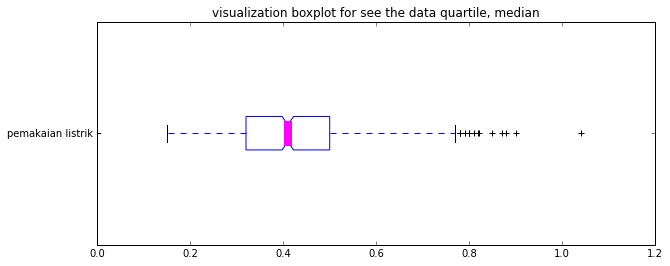

In [14]:
#visualization Boxpot Graph to see multiple quartile values ​​and also to see outliers in data_deskripsi

#create plot for chart boxplot

fig = plt.figure(figsize =(10, 4)) 
ax = fig.add_subplot(111)

# Make axis dan change data NaN to 0 .

bp = ax.boxplot(data_deskripsi['pemakaian_listrik'].fillna(0), patch_artist = True,
                notch ='True', vert = 0)
    
for median in bp['medians']:
    median.set(color ='#FF00FF',
               linewidth = 8)
ax.set_yticklabels(['pemakaian listrik'])
# add title
plt.title("visualization boxplot for see the data quartile, median")

### **Pre-processing**

**What is Data pre-processing?**
- Data Preparation : Memperbaiki / Improve Quality of the data for Model so that the performance of the data model is better (make data not ready will be ready)


In [15]:
#copy the data

data = df_data.copy()

**Transforming into Timeseries**
- Timeseries: data that describes something from time to time or historical period. Time series data usually consists of a sequence of dates and values ​​in the data for which they are intended.

In [16]:
#function transformation time series

def time_series(data_value):
  data_value["pemakaian_listrik"] = pd.to_numeric(data_value["pemakaian_listrik"], downcast="float") #mengconvert type data object to float
  data_value['tanggal'] = pd.to_datetime(data_value["tanggal"]) #mengconvert type data object to datetime
  return data_value


**Reindex data**
- reformat the date on the data to make it clear that the intervals coincide every 1 hour.

In [17]:
#function indexing
def reindex_date(data_value):
  
  data_value["pemakaian_listrik"] = pd.to_numeric(data_value["pemakaian_listrik"], downcast="float") #convert type data object to float
  data_value['tanggal'] = pd.to_datetime(data_value["tanggal"]) ##convert type data object to datetime

  data_value = data_value[['tanggal','pemakaian_listrik']] #just take 2 column.
  data_value = data_value.set_index('tanggal') #make index which was originally an integer to be a date time.

  #reformattted date
  
  lenght_data = len(data_value)
  tanggal_awal = data_value.index[0]
  data_value.index = pd.date_range(tanggal_awal, periods=lenght_data, freq='H')

  return data_value

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

#call function time series

data = time_series(data)

#call function reindex_date

data = reindex_date(data)

In [19]:
#Show data by start

data.head(5)

,pemakaian_listrik
2022-01-29 20:02:34,NaN
2022-01-29 21:02:34,0.67
2022-01-29 22:02:34,0.48
2022-01-29 23:02:34,0.47
2022-01-30 00:02:34,0.46


**Clearing the Data**
- Missing data will be filled with the average value of the entire data.
- Cleaning data is used to minimize noise, eg data outlier.

In [20]:
#fill data outlier with mean

data.loc[(data['pemakaian_listrik'] < lower_bound) | (data['pemakaian_listrik'] > upper_bound)] = np.nan

In [21]:
#make function missing value for the data

def cleaning_missingValue(data_value):
    try:
      if data_value['pemakaian_listrik'].isna().sum() > 0 or (data_value['pemakaian_listrik'] == 0).sum() > 0:
        print("")
        print("There is data that is empty, fill in the data with the average !")
        print("")
        time.sleep(1)
      
        #fill missing value and data zero with mean value in all data
        data_value['pemakaian_listrik'] = data_value['pemakaian_listrik'].fillna(data_value['pemakaian_listrik'].mean())
        data_value['pemakaian_listrik'] = data_value['pemakaian_listrik'].mask(data_value['pemakaian_listrik']==0).fillna(data_value['pemakaian_listrik'].mean())

        print("NULL data added successfully !")
      else:
        print("")
        print("Congratulations, no data is empty !")
      return round(data_value, 2)
    except:
      print('Data error occurred !!')

In [22]:
#call fuction missing value

data = cleaning_missingValue(data)


There is data that is empty, fill in the data with the average !

NULL data added successfully !


In [23]:
data.head(5)

,pemakaian_listrik
2022-01-29 20:02:34,0.41
2022-01-29 21:02:34,0.67
2022-01-29 22:02:34,0.48
2022-01-29 23:02:34,0.47
2022-01-30 00:02:34,0.46


## **2. Long Short-Term Memory**

**- Why Choose LSTM?**

1. From the amount of data. The data used is more than 500. Assume that the data is always growing continuously and the data will become very large. LSTM is very suitable for such a lot of data.

2. LSTM can handle sequential data such as time series and NLP.

3. LSTM can handle non-linear data types or there are outliers.

4. There is no need to assume the data is stationary or not. LSTM can handle both.

5. LSTM has a good performance in predicting electrical energy data such as this data.

**Splitting Data**
- Data Train: data will taken for training model LSTM
- Test data:  data will be taken for model evaluation

In [24]:
uji_name        = "pengujian_epoch"
uji_ke          = "uji-ke-3"
validasi_uji_ke = "validasi-ke-3"

In [25]:
#Calculate data train and testing by percent

data_all = len(data)

#Estimate Data by %

persen_data_test = 20
persen_data_train = 80

jumlah_data_test  = int((persen_data_test/100) * data_all)
jumlah_data_train = data_all - jumlah_data_test

print("jumlah data testing dan train :", (jumlah_data_test, jumlah_data_train))

jumlah data testing dan train : (104, 418)


In [26]:
#spliting data training and testing

train = data[:-104]
test = data[-104:]

print("shape data training: " + str(train.shape))
print("shape data testing: " + str(test.shape))

shape data training: (418, 1)
shape data testing: (104, 1)


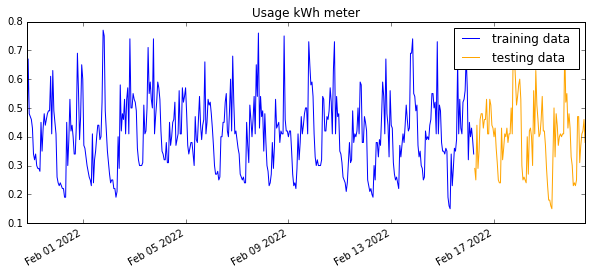

In [27]:
#plot data training dan data testing

train['pemakaian_listrik'].plot(figsize=(10,4),legend=True)
test['pemakaian_listrik'].plot(figsize=(10,4),legend=True, color="orange")

plt.legend(['training data ', 'testing data'])
plt.title('Usage kWh meter')
plt.show()

**Converting Data Into Sequence**
- where x1, x2, x3 is input for Deep Neural Network in LSTM
- where y1, y2, y3 is output (prediction) for Deep Neural Network in LSTM

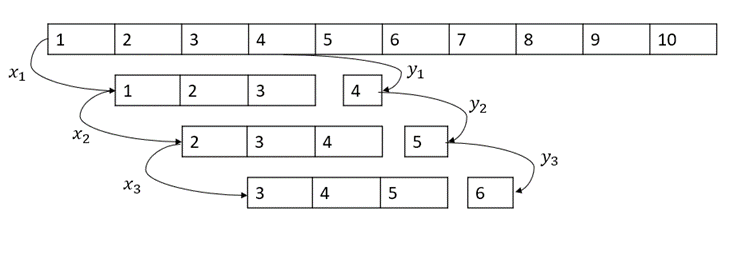

In [28]:
#transform into a sequence function.

def sequence_data_transformasi(data, window_size):

  df_as_np = data.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [29]:
#Change to data sequence

WINDOW_SIZE = 7

#for train data
input_train, output_train = sequence_data_transformasi(round(train['pemakaian_listrik'], 2), WINDOW_SIZE)

#for test data
input_test, output_test = sequence_data_transformasi(round(test['pemakaian_listrik'], 2), WINDOW_SIZE)

print(input_train.shape, output_train.shape)
print(input_test.shape, output_test.shape)


(411, 7, 1) (411,)
(97, 7, 1) (97,)


**Estimated Parameter Input**

In [30]:
n_input = WINDOW_SIZE
n_output_label = 1

**Estimated Parameter Dense, Neuron, Epoch, Batch Size, Learning Rate**


- Neuron = output dimension (dimensi keluaran) of neurons or Number of Neurons in Hidden Layer
- Dense = Number of Hidden Layers. Dense(1) is the output units of the hidden layer. If you give the dense function below that, then there are 2 hidden layers
- In the LSTM Layer there is 1 Hidden Layer.
- Epoch = When all data has gone through the training process on the Neural Network until it is returned to the beginning for one round (1 Epoch). because 1 epoch is too large to be entered into a computer, therefore we need to divide it into small units called batches. (karena pada 1 Epoch terlalu besar untuk dimasukkan kedalam komputer maka dari itu kita perlu membaginya kedalam satuan kecil yang disebut batches.)

- Batch Size = Batch Size is the number of sample data distributed to the Neural Network. eg data 50, and batch size = 5. then the order of data to be entered into the neural network is [1,2,3,4,5], continue [6,7,8,9,10]

**Selecting Metric Loss**

1. Is the data a case of classification or regression?
2. What metrics are appropriate for this case?

In the Regression Case, the Error Metric which is suitable for Knowing the Performance of the Training and Evaluation Model will be used.

1. Mean Square Error (MSE)



```
      MSE = 1/n (ytrue - ypred)^2
```

In [34]:
#Modeling data LSTM

model = Sequential([
    LSTM(8, activation='relu', input_shape=(n_input, n_output_label)),
    Dense(1),                                      
])

#call model and training data
#loss MSE is for the error function, the optimizer is to lower the value of the error (sgd)

model.compile(loss=['mse'], optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0010
))
print(model.summary())

#1 epochs = 1 time for all training data from top to bottom to completion. .
history = model.fit(input_train, output_train, validation_data=(input_test, output_test), batch_size=1, epochs=50) #fit generator to execute the model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
411/411 [==============================] - 2s 3ms/step - loss: 0.0230 - val_loss: 0.0119
Epoch 2/50
411/411 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0133
Epoch 3/50
411/411 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 4/50
411/411 [==============================] - 1s 2ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 5/50
411/411 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 6/50
41

**Evaluation Performance Model**

- Data evaluation using data test

- The model is said to be not overfitting and underfitting if the error value in the test data / validation data is not much different from the error in the training data.


Overfitting : where the prediction results on the training data are good and when tested with original data, the results are bad

Underfitting : where the prediction results on the training data and testing data are very bad.

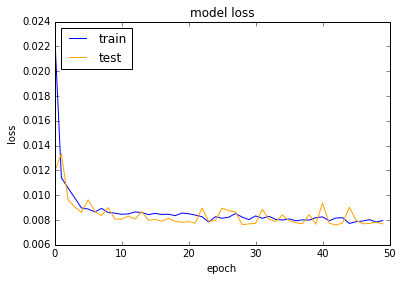

In [35]:
#make ploting loss function MSE

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color="orange")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('error-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()

In [36]:
#prediction for training data and transformed into dataframe

train_prediction = model.predict(input_train).flatten()
train_hasil= pd.DataFrame(data={'predict':train_prediction, 'train':output_train})
train_hasil.tail(5)

,predict,train
406,0.375907,0.45
407,0.377954,0.40
408,0.353656,0.43
409,0.373762,0.39
410,0.367339,0.34


Error MSE Data Training is:
411/411 [==============================] - 0s 1ms/step - loss: 0.0079
0.007866275496780872



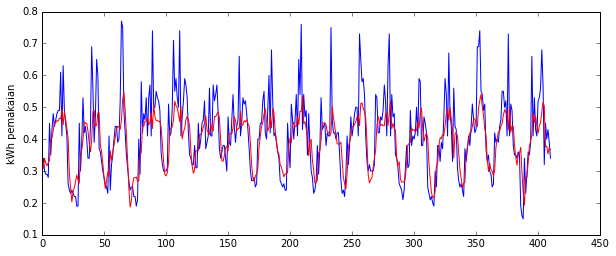

In [37]:
#Show the predicted results of train data in the form of a visualization graph
#model.evaluate to show final error by data. model.evalute error with MSE is same sklearn MSE 

print("Error MSE Data Training is:")
print(model.evaluate(input_train, output_train, batch_size=1,))
print("")

plt.figure(figsize=(10, 4))
plt.plot(train_hasil['train'],label='train', color='blue')
plt.plot(train_hasil['predict'], label='predict', color='red')
plt.ylabel("kWh pemakaian")
plt.xticks()
plt.yticks()
plt.savefig('grafik_prediksi_train-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()


In [38]:
#prediction for testing data and transformed into dataframe

test_prediction = model.predict(input_test).flatten()
test_hasil = pd.DataFrame(data={'predict':test_prediction, 'actual':output_test})
test_hasil.head(5)

,predict,actual
0,0.450838,0.48
1,0.466220,0.43
2,0.451907,0.46
3,0.457423,0.46
4,0.448940,0.53


Error MSE Data Testing is : 0.00768345



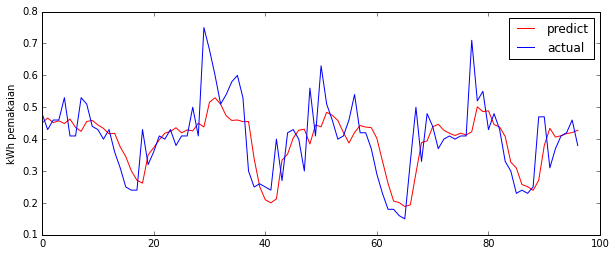

In [39]:
#Show the predicted results of train data in the form of a visualization graph

print('Error MSE Data Testing is :', mse(test_hasil['actual'], test_hasil['predict']))
print("")

plt.figure(figsize=(10, 4))
plt.plot(test_hasil['predict'], label='predict', color='red')
plt.plot(test_hasil['actual'],label='actual', color='blue')
plt.ylabel("kWh pemakaian")
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('grafik_prediksi_test-{}-{}-{}.png'.format(uji_name,uji_ke, validasi_uji_ke))
plt.show()

In [40]:
#or using function model.evaluate is simple. the result is same in the top

model.evaluate(input_test, output_test, batch_size=1)

97/97 [==============================] - 0s 1ms/step - loss: 0.0077


0.00768344895914197

**Model Save**
- save model to deployment

In [41]:
model.save('model_{}-{}-{}-MSE-{}.h5'.format(uji_name,uji_ke, validasi_uji_ke, mse(test_hasil['actual'], test_hasil['predict'])))